In [12]:
import numpy as np
import pandas as pd
import pybithumb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, LSTM, InputLayer
from scikeras.wrappers import KerasRegressor
from sklearn.ensemble import AdaBoostRegressor

In [13]:
# Getting ETH's OHLCV (open, high, low, close, volume) data from Bithumb
df = pybithumb.get_ohlcv("ETH", interval="hour")
df.reset_index(inplace=True)
print(df.head())

                 time       open       high        low      close      volume
0 2023-10-12 06:00:00  2133000.0  2137000.0  2131000.0  2137000.0   53.915968
1 2023-10-12 07:00:00  2137000.0  2141000.0  2136000.0  2138000.0  141.400006
2 2023-10-12 08:00:00  2138000.0  2139000.0  2135000.0  2139000.0   97.991447
3 2023-10-12 09:00:00  2138000.0  2139000.0  2126000.0  2126000.0  151.913340
4 2023-10-12 10:00:00  2127000.0  2127000.0  2120000.0  2123000.0  284.734123


Text(0.5, 1.0, 'ETH')

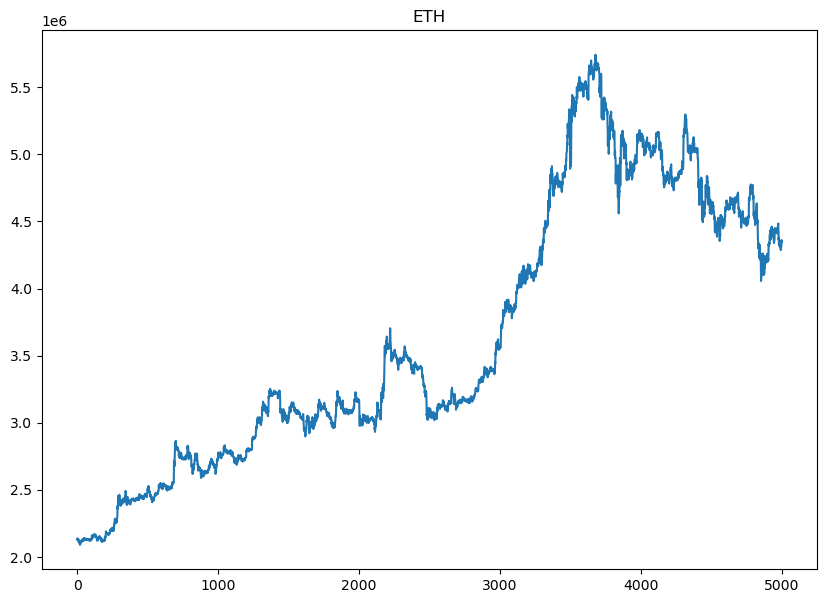

In [30]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(df['open'])
plt.title('ETH')

Text(0.5, 1.0, 'ETH rolling window=10')

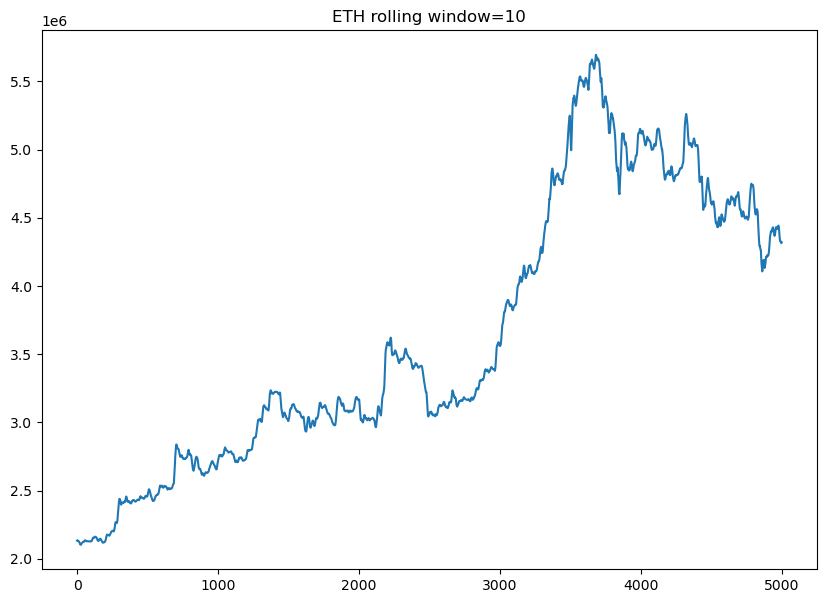

In [35]:
# Smoothing the data
# mean rolling graph
rolling_10 = df['open'].rolling(10, min_periods=0).mean()
plt.plot(rolling_10)
plt.title('ETH rolling window=10')

Text(0.5, 1.0, 'ETH scaled')

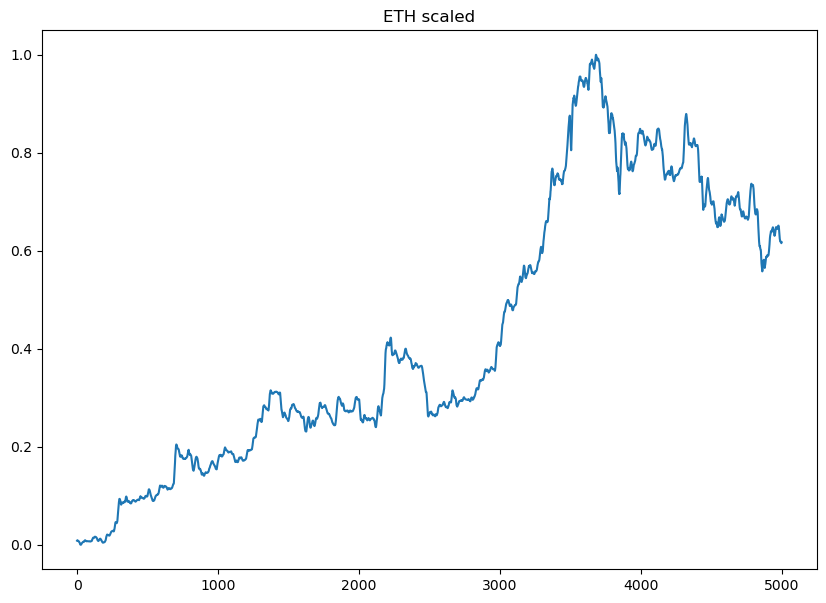

In [42]:
# Scaling the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(rolling_10.values.reshape(-1,1))

plt.plot(scaled_data)
plt.title('ETH scaled')

In [15]:
def preprocess(series, window_size=None, scaling=True):

    if window_size!=None:
        series = series.rolling(window_size, min_periods=0).mean()
    array = np.array(series)
    
    if scaling==True:
        scaler = MinMaxScaler()
        training_data = scaler.fit_transform(array.reshape(-1,1))
    else:
        scaler = None

    return training_data, scaler

def make_dataset(training_data, t, h=0, test_size=0.2):
    
    X_train = []
    y_train = []
    for i in range(t, len(training_data)-h):
        X_train.append(training_data[i-t:i])
        y_train.append(training_data[i+h])
    X = np.array(X_train)
    y = np.array(y_train)

    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    return X_train,X_test,y_train,y_test

training_data, scaler = preprocess(df['open'], window_size=10)
X_train,X_test,y_train,y_test = make_dataset(training_data, t = 168)




In [16]:
def MAE(y_true, y_pred):
    return "{:.2e}".format(np.mean(np.abs(y_true-y_pred)))

def MSE(y_true, y_pred):
    return "{:.2e}".format(np.mean(np.square(y_true-y_pred)))

def RMSE(y_true, y_pred):
    return "{:.2e}".format(np.sqrt(np.mean(np.square(y_true-y_pred))))



In [17]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],1)))
model.add(GRU(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')

# adaboost
GRU_Predictors = KerasRegressor(build_fn=lambda:model, epochs=20, batch_size=30)
final_model = AdaBoostRegressor(GRU_Predictors, n_estimators=5, random_state=42)

final_model.fit(X_train,y_train)

Epoch 1/20


/Users/hataehyeok/anaconda3/envs/test_timefor/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Users/hataehyeok/anaconda3/envs/test_timefor/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/hataehyeok/anaconda3/envs/test_timefor/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0288
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0024
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0019
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0016
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.0016
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0018
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0015
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.0014
Epoch 9/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0013
Epoch 10/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.0011
Epoch 11/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.0012
Epoch 12/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.0011
Epoch 13/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0012
Epoch 14/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 9.5866e-04
Epoch 15/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/s

/Users/hataehyeok/anaconda3/envs/test_timefor/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 9.3147e-04
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 8.0779e-04
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 8.1375e-04
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 8.3036e-04
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 8.0039e-04
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 7.5390e-04
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 6.4421e-04
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 7.8452e-04
Epoch 9/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 7.6376e-04
Epoch 10/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 7.1560e-04
Epoch 11/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 7.3690e-04
Epoch 12/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 7.4261e-04
Epoch 13/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 7.0392e-04
Epoch 14/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 6.8485e-0

/Users/hataehyeok/anaconda3/envs/test_timefor/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 8.1254e-04
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 8.3436e-04
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 7.9094e-04
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 8.3445e-04
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 8.4444e-04
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 8.2634e-04
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 7.9287e-04
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 8.0287e-04
Epoch 9/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 8.5738e-04
Epoch 10/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 7.7832e-04
Epoch 11/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 8.2394e-04
Epoch 12/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 8.7180e-04
Epoch 13/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 8.1522e-04
Epoch 14/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 7.6287e-0

/Users/hataehyeok/anaconda3/envs/test_timefor/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 8.6920e-04
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 8.7398e-04
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 8.1533e-04
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 7.8964e-04
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 8.4962e-04
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 8.0118e-04
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 8.1351e-04
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 8.1601e-04
Epoch 9/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 8.2284e-04
Epoch 10/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 7.8848e-04
Epoch 11/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 8.5131e-04
Epoch 12/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 8.1944e-04
Epoch 13/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 8.5531e-04
Epoch 14/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 8.2902e-0

/Users/hataehyeok/anaconda3/envs/test_timefor/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 7.4638e-04
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 7.4824e-04
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 7.5734e-04
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 7.7333e-04
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 7.6402e-04
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 9.3612e-04
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 7.3284e-04
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 8.0260e-04
Epoch 9/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 7.6498e-04
Epoch 10/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 7.0482e-04
Epoch 11/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 7.6626e-04
Epoch 12/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 7.6483e-04
Epoch 13/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 8.2557e-04
Epoch 14/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 7.0294e-0

AdaBoostRegressor(estimator=KerasRegressor(batch_size=30, build_fn=<function <lambda> at 0x317ece8e0>, epochs=20),
                  n_estimators=5, random_state=42)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


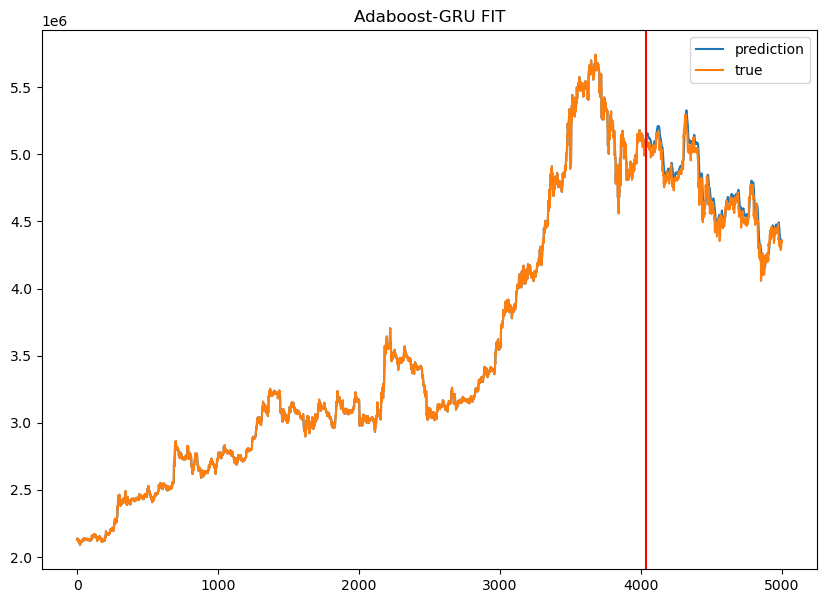

In [31]:
preds = final_model.predict(X_test)
preds = scaler.inverse_transform(preds.reshape(-1,1))
preds_series = np.hstack([df['open'][:-len(preds)], preds.squeeze(1)])

plt.plot(preds_series, label='prediction')
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(df['open'], label='true')
plt.axvline(x=len(df['open'])-len(preds), color='r')
plt.legend()
plt.title('Adaboost-GRU FIT')
plt.show()

In [19]:
y_true = df['open'][-len(preds):]
y_pred = preds.squeeze(1)

print(MAE(y_true, y_pred))
print(MSE(y_true, y_pred))
print(RMSE(y_true, y_pred))


3.79e+04
2.82e+09
5.31e+04


In [20]:
# LSTM-adaboost FIT

model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')

LSTM_Predictors = KerasRegressor(build_fn=lambda:model, epochs=20, batch_size=30)
final_model = AdaBoostRegressor(LSTM_Predictors, n_estimators=5, random_state=42)

final_model.fit(X_train,y_train)

Epoch 1/20


/Users/hataehyeok/anaconda3/envs/test_timefor/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Users/hataehyeok/anaconda3/envs/test_timefor/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/hataehyeok/anaconda3/envs/test_timefor/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0183
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.0025
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.0022
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0018
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0017
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.0019
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0016
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0014
Epoch 9/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0013
Epoch 10/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0013
Epoch 11/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0011
Epoch 12/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0010
Epoch 13/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 9.7808e-04
Epoch 14/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 9.8612e-04
Epoch 15/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60

/Users/hataehyeok/anaconda3/envs/test_timefor/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 8.6579e-04
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 9.9933e-04
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 8.4036e-04
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 7.9999e-04
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 9.7396e-04
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 8.7275e-04
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 8.2057e-04
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 8.2419e-04
Epoch 9/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 7.3566e-04
Epoch 10/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 8.7754e-04
Epoch 11/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 7.6488e-04
Epoch 12/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 7.5175e-04
Epoch 13/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 7.1757e-04
Epoch 14/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 7.0256e-0

/Users/hataehyeok/anaconda3/envs/test_timefor/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 8.2646e-04
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 9.9197e-04
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 8.9948e-04
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 7.9014e-04
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 9.0636e-04
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 8.9197e-04
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 8.2658e-04
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 7.6031e-04
Epoch 9/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 8.8154e-04
Epoch 10/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 9.4832e-04
Epoch 11/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 8.8124e-04
Epoch 12/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 7.9256e-04
Epoch 13/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 7.9477e-04
Epoch 14/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 8.7628e-0

/Users/hataehyeok/anaconda3/envs/test_timefor/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 9.4640e-04
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0010
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 9.2048e-04
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 9.2955e-04
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 9.0449e-04
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 8.5263e-04
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 9.3782e-04
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 9.2481e-04
Epoch 9/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 8.9707e-04
Epoch 10/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 8.9493e-04
Epoch 11/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 9.3515e-04
Epoch 12/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0010
Epoch 13/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 9.5740e-04
Epoch 14/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0010
Epoch 15/2

/Users/hataehyeok/anaconda3/envs/test_timefor/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 9.9244e-04
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 9.8663e-04
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 9.2909e-04
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 9.4995e-04
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 9.1968e-04
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 8.9853e-04
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 8.7578e-04
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 9.6025e-04
Epoch 9/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 8.9161e-04
Epoch 10/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 9.9366e-04
Epoch 11/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 9.2044e-04
Epoch 12/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 9.2079e-04
Epoch 13/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 8.8508e-04
Epoch 14/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 9.2034e-0

AdaBoostRegressor(estimator=KerasRegressor(batch_size=30, build_fn=<function <lambda> at 0x346007880>, epochs=20),
                  n_estimators=5, random_state=42)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


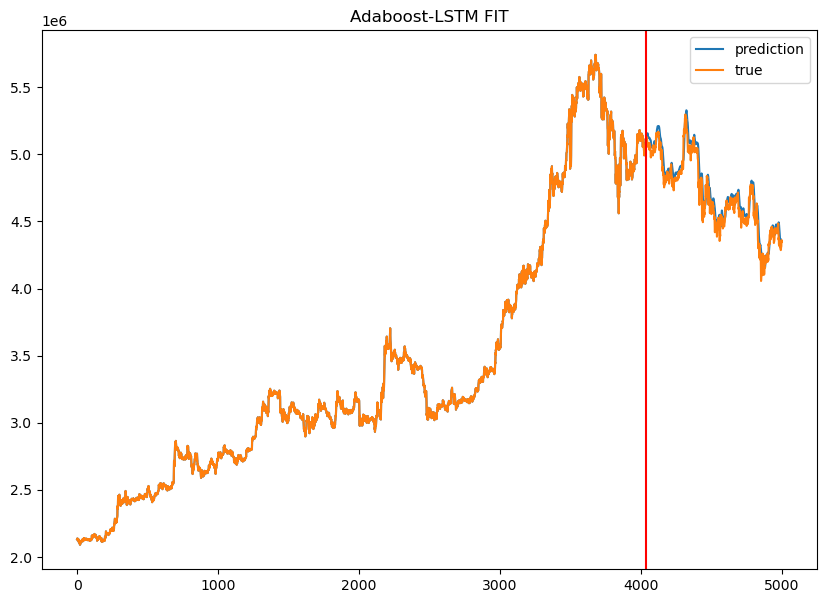

In [32]:
preds = final_model.predict(X_test)
preds = scaler.inverse_transform(preds.reshape(-1,1))
preds_series = np.hstack([df['open'][:-len(preds)], preds.squeeze(1)])

plt.plot(preds_series, label='prediction')
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(df['open'], label='true')
plt.axvline(x=len(df['open'])-len(preds), color='r')
plt.legend()
plt.title('Adaboost-LSTM FIT')
plt.show()


In [22]:
y_true = df['open'][-len(preds):]
y_pred = preds.squeeze(1)

print(MAE(y_true, y_pred))
print(MSE(y_true, y_pred))
print(RMSE(y_true, y_pred))

5.93e+04
5.48e+09
7.40e+04


Epoch 1/20


/Users/hataehyeok/anaconda3/envs/test_timefor/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.0086 - val_loss: 3.4718e-04
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 8.8377e-04 - val_loss: 0.0016
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 8.7476e-04 - val_loss: 1.9161e-04
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 6.7155e-04 - val_loss: 5.7859e-05
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 6.2154e-04 - val_loss: 0.0020
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 5.7298e-04 - val_loss: 4.5379e-05
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 5.3575e-04 - val_loss: 2.2122e-04
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 4.4603e-04 - val_loss: 3.2995e-04
Epoch 9/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 4.6740e-04 - val_loss: 2.0123e-04
Epoch 10/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 3.9980e-04 - val_loss: 2.6251e-04
Epoch 11/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 3.3804e-04

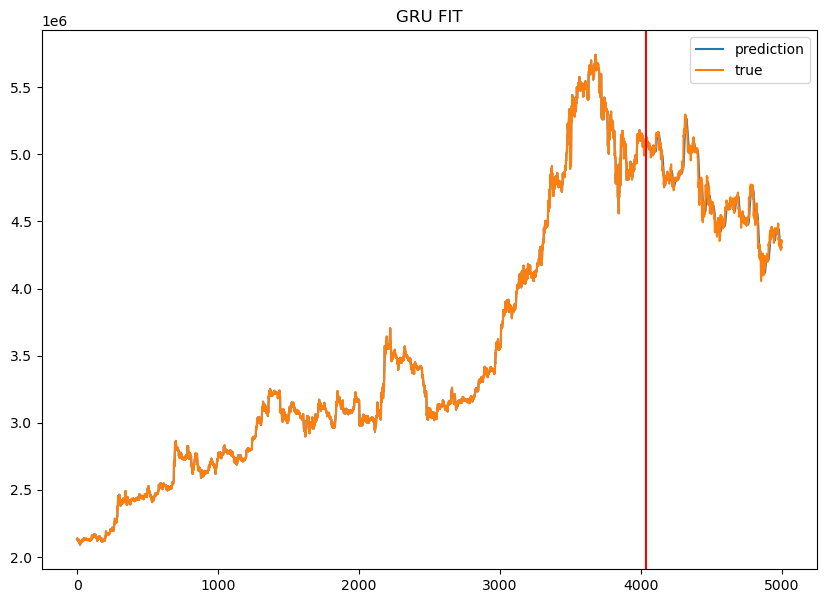

In [33]:
import tensorflow as tf

tf.random.set_seed(1)

# GRU FIT
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],1)))
model.add(GRU(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, batch_size=30, epochs=20, validation_split=0.2)

preds = model.predict(X_test)
preds = scaler.inverse_transform(preds.reshape(-1,1))
preds_series = np.hstack([df['open'][:-len(preds)], preds.squeeze(1)])
plt.plot(preds_series, label='prediction')

plt.plot(df['open'], label='true')
plt.rcParams["figure.figsize"] = (10,7)
plt.axvline(x=len(df['open'])-len(preds), color='r')
plt.title('GRU FIT')
plt.legend()
plt.show()

In [26]:
y_true = df['open'][-len(preds):]
y_pred = preds.squeeze(1)

In [27]:
# LSTM FIT

model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train,y_train,batch_size=30,epochs=20,validation_split=0.2)

Epoch 1/20


/Users/hataehyeok/anaconda3/envs/test_timefor/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 0.0139 - val_loss: 0.0019
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 0.0010 - val_loss: 2.4472e-04
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - loss: 8.1840e-04 - val_loss: 2.8840e-04
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 7.1537e-04 - val_loss: 0.0013
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 6.6977e-04 - val_loss: 0.0013
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 6.6867e-04 - val_loss: 4.3868e-04
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 5.7362e-04 - val_loss: 7.1478e-04
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 5.6904e-04 - val_loss: 1.4528e-04
Epoch 9/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 5.3670e-04 - val_loss: 1.7448e-04
Epoch 10/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 4.6053e-04 - val_loss: 2.5913e-04
Epoch 11/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 4.6288e-04 - val_l

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


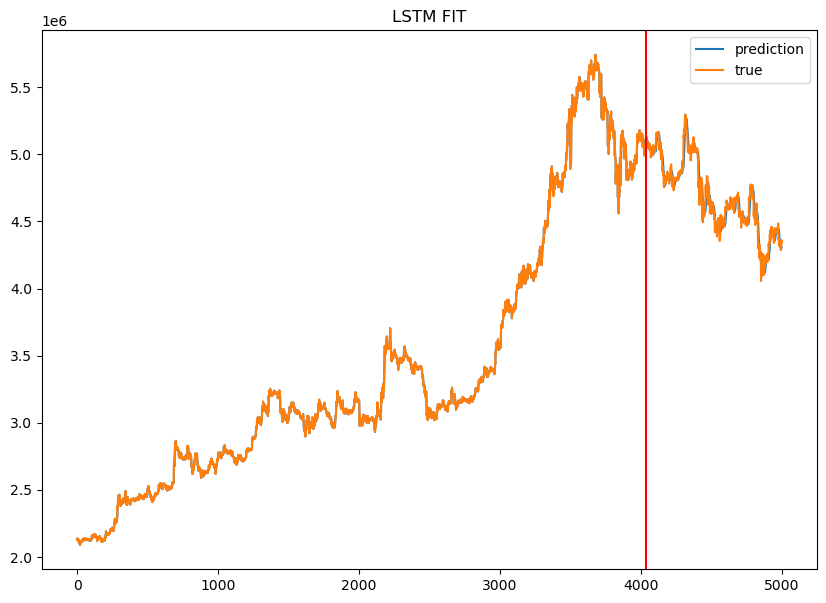

In [34]:
preds = model.predict(X_test)
preds = scaler.inverse_transform(preds.reshape(-1,1))
preds_series = np.hstack([df['open'][:-len(preds)], preds.squeeze(1)])

plt.plot(preds_series, label='prediction')
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(df['open'], label='true')
plt.axvline(x=len(df['open'])-len(preds), color='r')
plt.legend()
plt.title('LSTM FIT')
plt.show()

In [29]:
y_true = df['open'][-len(preds):]
y_pred = preds.squeeze(1)

print(MAE(y_true, y_pred))
print(MSE(y_true, y_pred))
print(RMSE(y_true, y_pred))

6.90e+04
6.96e+09
8.34e+04
